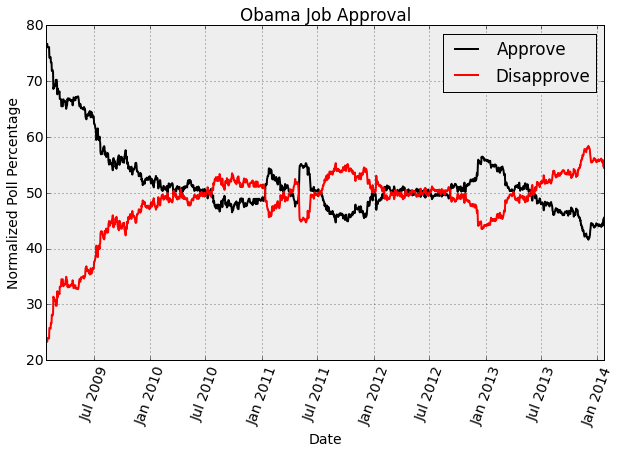

In [2]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

from fnmatch import fnmatch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from pattern import web
import re

import requests
import StringIO
import zipfile
import scipy.stats 

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

def getPollXML(pollId = 1171):
    #the default poll Id retrieves the data for the Obama-Romney race
    address = "http://charts.realclearpolitics.com/charts/%d.xml" % pollId
    return requests.get(address).text

def _strip(s):
    """This function removes non-letter characters from a word
    for example _strip('Hi there!') == 'Hi there'
    """
    return re.sub(r'[\W_]+', '', s)

def plot_colors(xml):
    """
    Given an XML document like the link above, returns a python dictionary
    that maps a graph title to a graph color.
    
    Both the title and color are parsed from attributes of the <graph> tag:
    <graph title="the title", color="#ff0000"> -> {'the title': '#ff0000'}
    
    These colors are in "hex string" format. This page explains them:
    http://coding.smashingmagazine.com/2012/10/04/the-code-side-of-color/
    
    Example
    -------
    >>> plot_colors(get_poll_xml(1044))
    {u'Approve': u'#000000', u'Disapprove': u'#FF0000'}
    """
    dom = web.Element(xml)
    result = {}
    for graph in dom.by_tag('graph'):
        title = _strip(graph.attributes['title'])
        result[title] = graph.attributes['color']
    return result

def rcpPollData(inputXMLData):
    dom = web.Element(inputXMLData)
    result = {}
    
    dates = dom.by_tag('series')[0]    
    dates = {n.attributes['xid']: str(n.content) for n in dates.by_tag('value')}
    
    keys = dates.keys()
    
    result['date'] = pd.to_datetime([dates[k] for k in keys])
    
    for graph in dom.by_tag('graph'):
        name = graph.attributes['title']
        data = {n.attributes['xid']: float(n.content) 
                if n.content else np.nan for n in graph.by_tag('value')}
        result[name] = [data[k] for k in keys]
        
    result = pd.DataFrame(result)    
    result = result.sort(columns=['date'])
        
    return result

def poll_plot(poll_id):
    """
    Make a plot of an RCP Poll over time
    
    Parameters
    ----------
    poll_id : int
        An RCP poll identifier
    """

    # hey, you wrote two of these functions. Thanks for that!
    xml = getPollXML(poll_id)
    data = rcpPollData(xml)
    colors = plot_colors(xml)

    #remove characters like apostrophes
    data = data.rename(columns = {c: _strip(c) for c in data.columns})

    #normalize poll numbers so they add to 100%    
    norm = data[colors.keys()].sum(axis=1) / 100    
    for c in colors.keys():
        data[c] /= norm
    
    for label, color in colors.items():
        plt.plot(data.date, data[label], color=color, label=label)        
        
    plt.xticks(rotation=70)
    plt.legend(loc='best')
    plt.xlabel("Date")
    plt.ylabel("Normalized Poll Percentage")
    
poll_plot(1044)
plt.title("Obama Job Approval")

In [3]:
def getZIP(zipFileName):
    r = requests.get(zipFileName).content
    s = StringIO.StringIO(r)
    zf = zipfile.ZipFile(s, 'r') # Read in a list of zipped files
    return zf



In [4]:
url = 'http://seanlahman.com/files/database/lahman-csv_2014-02-14.zip'
zf = getZIP(url)

tablenames = zf.namelist()
salaries = pd.read_csv(zf.open(tablenames[tablenames.index('Salaries.csv')]))
print "Number of rows: %i" % salaries.shape[0]
salaries.head()

Number of rows: 23956


,yearID,teamID,lgID,playerID,salary
0,1985,BAL,AL,murraed02,1472819
1,1985,BAL,AL,lynnfr01,1090000
2,1985,BAL,AL,ripkeca01,800000
3,1985,BAL,AL,lacyle01,725000
4,1985,BAL,AL,flanami01,641667


In [5]:
teams = pd.read_csv(zf.open(tablenames[tablenames.index('Teams.csv')]))
teams = teams[['yearID', 'teamID', 'W']]
print "Number of rows: %i" % teams.shape[0]
teams.head()

Number of rows: 2745


,yearID,teamID,W
0,1871,PH1,21
1,1871,CH1,19
2,1871,BS1,20
3,1871,WS3,15
4,1871,NY2,16


In [6]:
totSalaries = salaries.groupby(['yearID','teamID'], as_index=False).sum()
totSalaries.head()

,yearID,teamID,salary
0,1985,ATL,14807000
1,1985,BAL,11560712
2,1985,BOS,10897560
3,1985,CAL,14427894
4,1985,CHA,9846178


In [7]:
joined = pd.merge(totSalaries, teams, how="inner", on=['yearID', 'teamID'])
joined.head()

,yearID,teamID,salary,W
0,1985,ATL,14807000,66
1,1985,BAL,11560712,83
2,1985,BOS,10897560,81
3,1985,CAL,14427894,90
4,1985,CHA,9846178,85


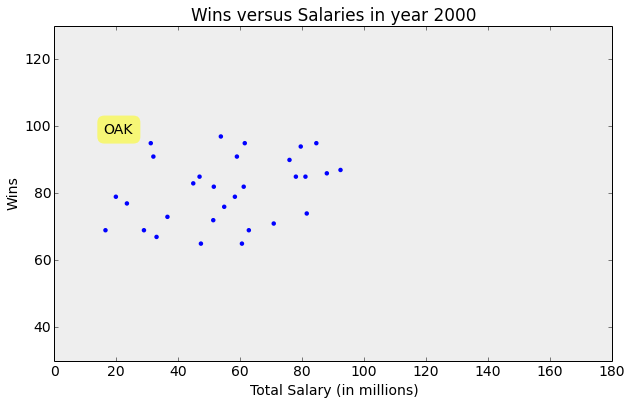

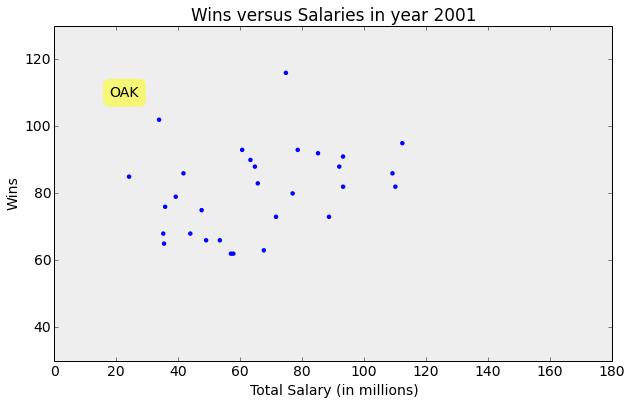

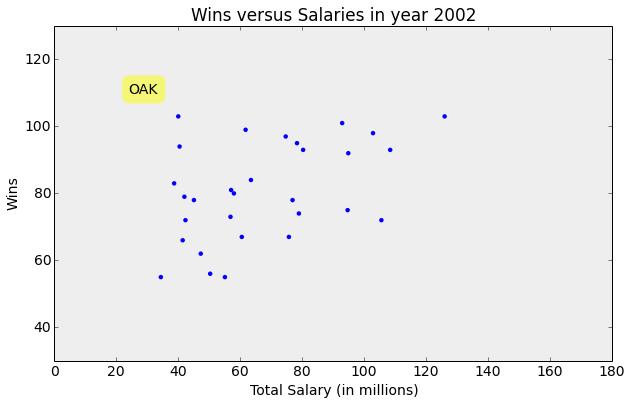

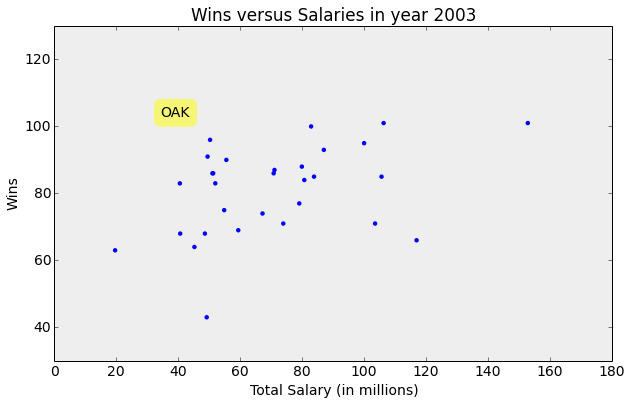

In [8]:
teamName = 'OAK'
years = np.arange(2000, 2004)

for yr in years: 
    df = joined[joined['yearID'] == yr]
    plt.scatter(df['salary'] / 1e6, df['W'])
    plt.title('Wins versus Salaries in year ' + str(yr))
    plt.xlabel('Total Salary (in millions)')
    plt.ylabel('Wins')
    plt.xlim(0, 180)
    plt.ylim(30, 130)
    plt.grid()
    plt.annotate(teamName, 
        xy = (df['salary'][df['teamID'] == teamName] / 1e6,  df['W'][df['teamID'] == teamName]), 
        xytext = (-20, 20), textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', facecolor = 'black' , connectionstyle = 'arc3,rad=0'))
    
    plt.show()

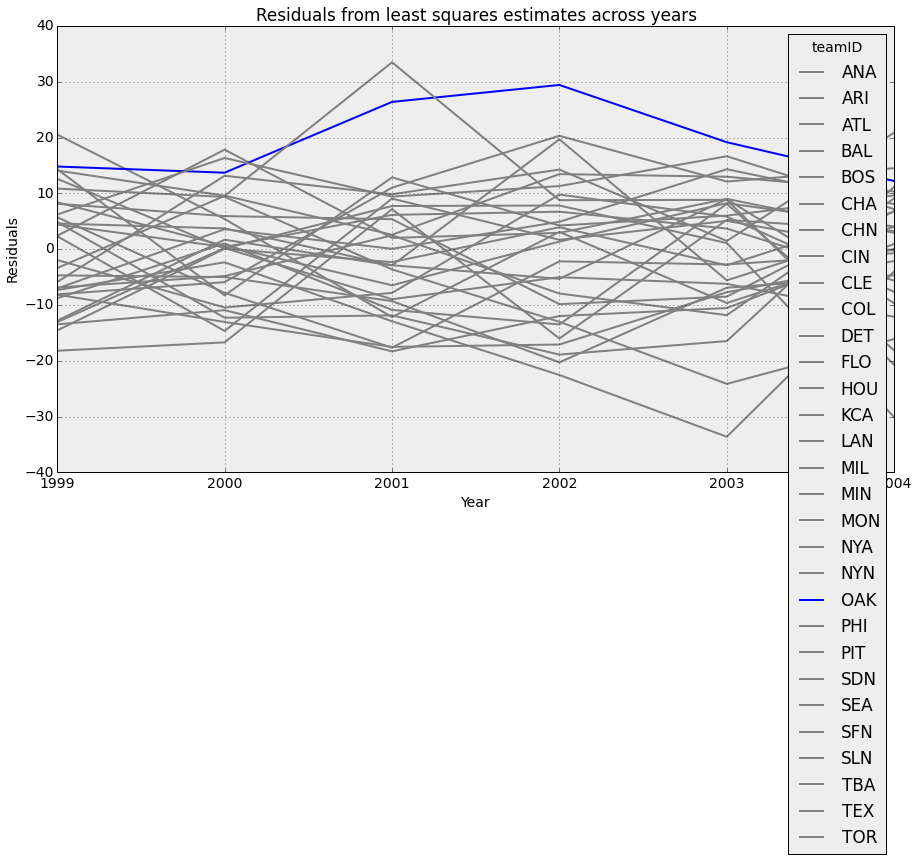

In [9]:
teamName = 'OAK'
years = np.arange(1999, 2005)
residData = pd.DataFrame()

for yr in years: 
    df = joined[joined['yearID'] == yr]
    x_list = df['salary'].values / 1e6
    y_list = df['W'].values

    # least squares estimates
    A = np.array([x_list, np.ones(len(x_list))])
    y = y_list
    w = np.linalg.lstsq(A.T,y)[0] # coefficients
    yhat = (w[0]*x_list+w[1]) # regression line
    residData[yr] = y - yhat
  
residData.index = df['teamID']
residData = residData.T
residData.index = residData.index.format()

residData.plot(title = 'Residuals from least squares estimates across years', figsize = (15, 8),
               color=map(lambda x: 'blue' if x=='OAK' else 'gray',df.teamID))
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.show()

In [5]:
countries = pd.read_csv('https://raw.githubusercontent.com/cs109/2014_data/master/countries.csv')
print "Number of rows: %i" % countries.shape[0]
countries.head()

Number of rows: 194


,Country,Region
0,Algeria,AFRICA
1,Angola,AFRICA
2,Benin,AFRICA
3,Botswana,AFRICA
4,Burkina,AFRICA


In [22]:
incomeLink = 'https://spreadsheets.google.com/pub?key=phAwcNAVuyj1jiMAkmq1iMg&output=xls'
source = StringIO.StringIO(requests.get(incomeLink).content)
income = pd.read_excel(source, sheetname = "Data")
income.head()

,GDP per capita,1800,1801,1802,1803,1804,1805,1806,1807,1808,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,Abkhazia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,634.400014,634.400014,634.400014,634.400014,634.400014,634.400014,634.400014,634.400014,634.400014,...,1081.472262,1174.582145,1193.282161,1321.945588,1323.495832,1552.033398,1632.338112,1695.153436,1885.356711,1906.651322
2,Akrotiri and Dhekelia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,860.587966,861.481754,862.376469,863.272114,864.168689,865.066196,865.964634,866.864005,867.764311,...,7322.045206,7685.262481,8090.423280,8528.395747,9111.710122,9377.045354,9656.957169,9897.179958,10122.606169,10296.343709
4,Algeria,1360.000000,1361.635788,1363.271576,1364.907363,1366.543151,1368.178939,1369.814727,1371.450514,1373.086302,...,11574.631939,12077.229365,12088.087622,12289.027259,12314.346983,12285.128876,12494.067036,12605.771553,12751.716076,12956.598567


In [23]:
income.index = income[income.columns[0]]
income = income.drop(income.columns[0], axis = 1)
income.columns = map(lambda x: int(x), income.columns)
income = income.transpose()
income.head()

GDP per capita,Abkhazia,Afghanistan,Akrotiri and Dhekelia,Albania,Algeria,American Samoa,Andorra,Angola,Anguilla,Antigua and Barbuda,...,Western Sahara,Vietnam,Virgin Islands (U.S.),Yemen Arab Republic (Former),Yemen Democratic (Former),"Yemen, Rep.",Yugoslavia,Zambia,Zimbabwe,Åland
1800,NaN,634.400014,NaN,860.587966,1360.000000,NaN,1260.00,650.000027,NaN,796.593372,...,NaN,732.126075,NaN,NaN,NaN,923.000000,NaN,698.213614,914.519610,NaN
1801,NaN,634.400014,NaN,861.481754,1361.635788,NaN,1262.15,653.539850,NaN,796.593372,...,NaN,732.126075,NaN,NaN,NaN,926.047067,NaN,700.018066,915.557336,NaN
1802,NaN,634.400014,NaN,862.376469,1363.271576,NaN,1264.30,657.079673,NaN,796.593372,...,NaN,732.126075,NaN,NaN,NaN,929.094134,NaN,701.822518,916.595062,NaN
1803,NaN,634.400014,NaN,863.272114,1364.907363,NaN,1266.45,660.619496,NaN,796.593372,...,NaN,732.126075,NaN,NaN,NaN,932.141201,NaN,703.626970,917.632788,NaN
1804,NaN,634.400014,NaN,864.168689,1366.543151,NaN,1268.60,664.159319,NaN,796.593372,...,NaN,732.126075,NaN,NaN,NaN,935.188268,NaN,705.431423,918.670514,NaN


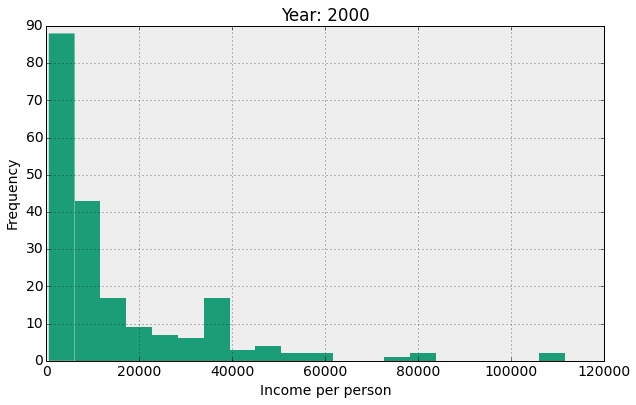

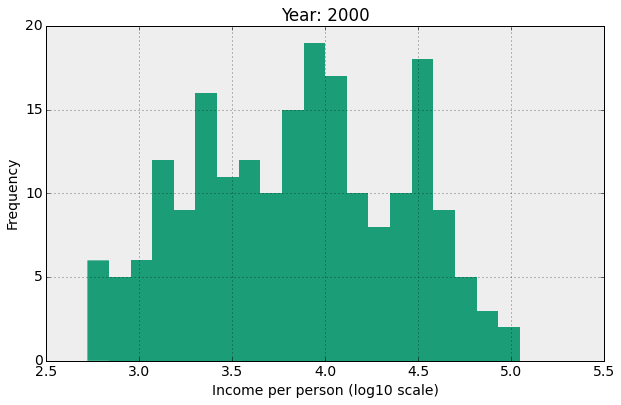

In [24]:
year = 2000
plt.plot(subplots=True)
plt.hist(income.ix[year].dropna().values, bins = 20)
plt.title('Year: %i' % year)
plt.xlabel('Income per person')
plt.ylabel('Frequency')
plt.show()

plt.hist(np.log10(income.ix[year].dropna().values), bins = 20)
plt.title('Year: %i' % year)
plt.xlabel('Income per person (log10 scale)')
plt.ylabel('Frequency')
plt.show()

In [25]:
def mergeByYear(year):
    data = pd.DataFrame(income.ix[year].values, columns = ['Income'])
    data['Country'] = income.columns
    joined = pd.merge(data, countries, how="inner", on=['Country'])
    joined.Income = np.round(joined.Income, 2)
    return joined

mergeByYear(2010).head()

,Income,Country,Region
0,1632.34,Afghanistan,ASIA
1,9656.96,Albania,EUROPE
2,12494.07,Algeria,AFRICA
3,38981.93,Andorra,EUROPE
4,7021.58,Angola,AFRICA


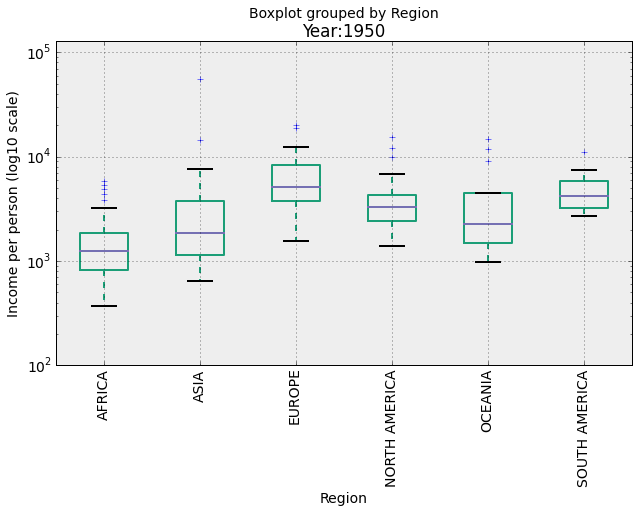

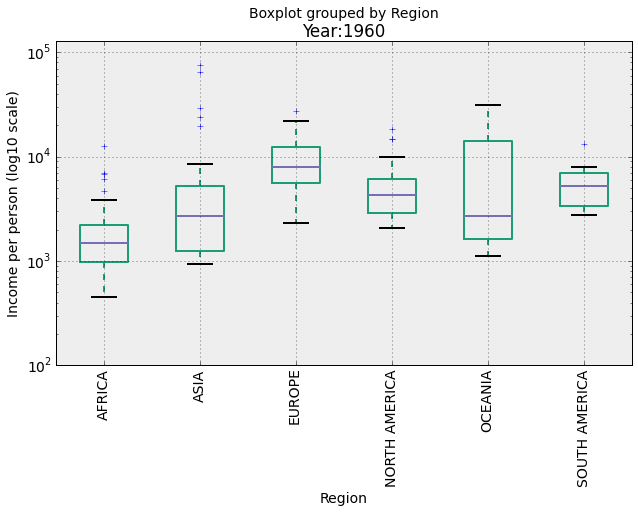

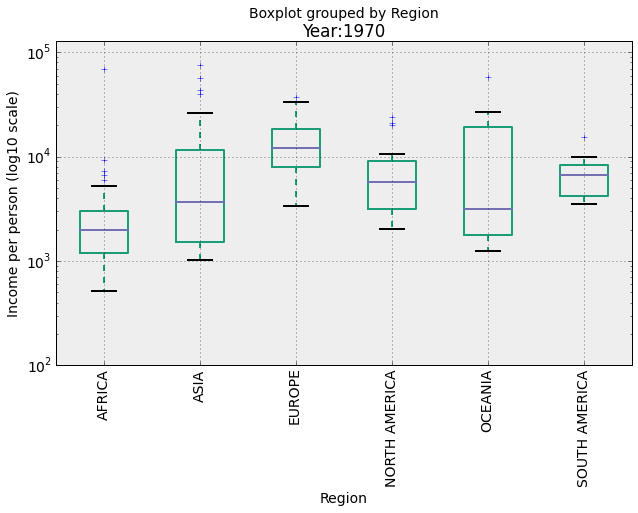

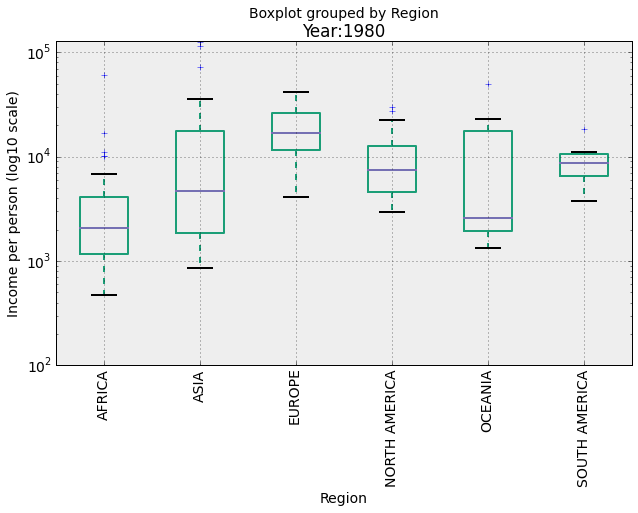

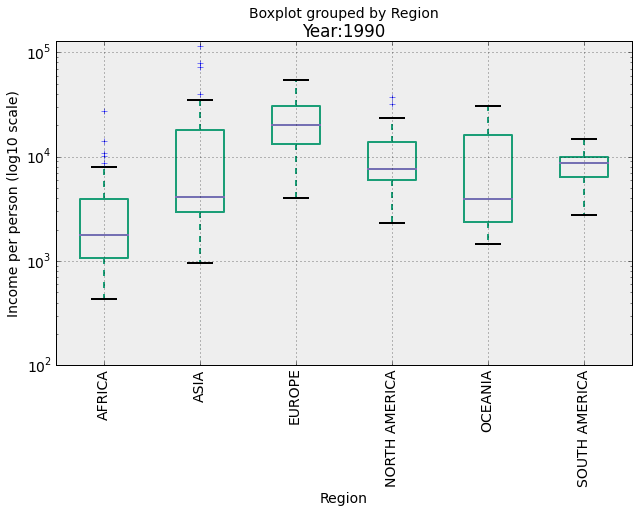

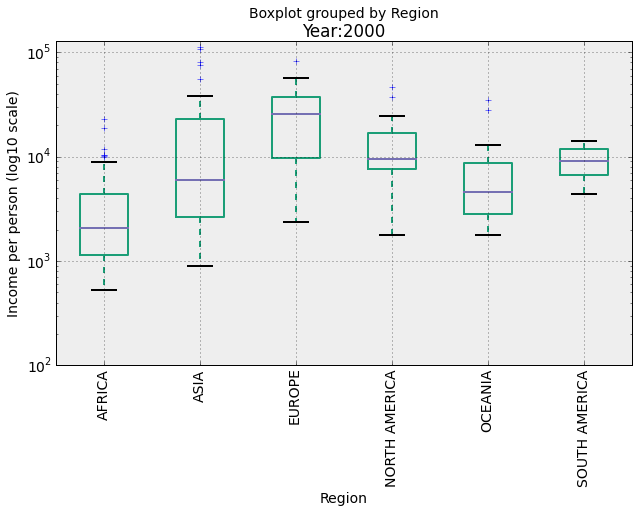

In [26]:
years = np.arange(1950, 2010, 10)

for yr in years:
    df = mergeByYear(yr)
    df.boxplot('Income', by = 'Region', rot = 90)
    plt.title("Year:" + str(yr))
    plt.ylabel('Income per person (log10 scale)')
    plt.ylim(10**2, 10.5 **5)
    plt.yscale('log')

In [27]:
"""
Function
--------
ratioNormals

Return ratio of these two proportions: 
    Pr(X > a)/Pr(Y > a) as function of 
    the difference in the average of X 
    and the average of Y. 

Parameters
----------
diff : difference in the average of X 
    and the average of Y. 
a : cutoff value

Returns
-------
Returns ratio of these two proportions: 
    Pr(X > a)/Pr(Y > a)
    
Example
-------
>>> ratioNormals(diff = 1, a = 2)
"""
#your code here

def ratioNormals(diff, a):
    X = scipy.stats.norm(loc=diff, scale=1)
    Y = scipy.stats.norm(loc=0, scale=1) 
    return X.sf(a) / Y.sf(a)

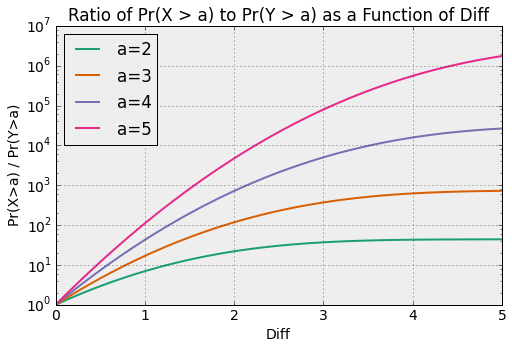

In [28]:
#your code here

# let diff range from 0 to 5 
diffs = np.linspace(0, 5, 50)
a_values = range(2,6)

# Plot separate curves for 
# Pr(X > a) / Pr(Y > a) as a function of diff
# for all given values of a
plt.figure(figsize=(8,5));
for a in a_values:
    ratios = [ratioNormals(diff, a) for diff in diffs]
    plt.plot(diffs, ratios)
    
# Labels
plt.legend(["a={}".format(a) for a in a_values], loc=0);
plt.xlabel('Diff');
plt.ylabel('Pr(X>a) / Pr(Y>a)');
plt.title('Ratio of Pr(X > a) to Pr(Y > a) as a Function of Diff');

# Using a log scale so you can actually see the curves
plt.yscale('log')

In [29]:
merged = mergeByYear(2012).groupby('Region', as_index=False).mean()
merged = merged.loc[(merged.Region == "ASIA") | (merged.Region == "SOUTH AMERICA")]
merged.Income = np.round(merged.Income, 2)
merged

,Region,Income
1,ASIA,22997.58
5,SOUTH AMERICA,12956.60


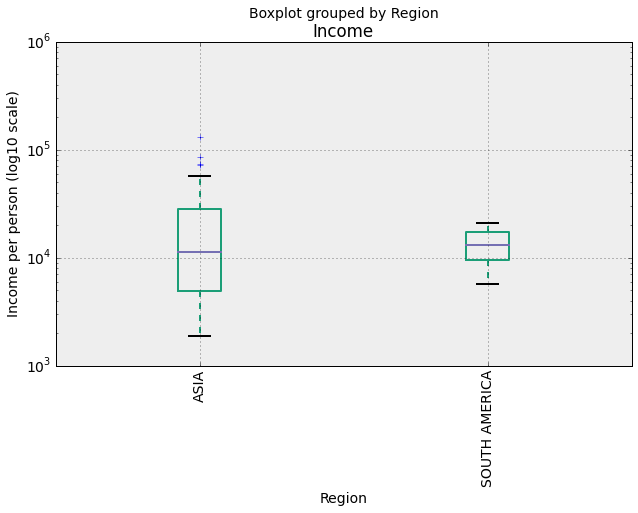

In [30]:
df = mergeByYear(2012)
df = df.loc[(df.Region == "ASIA") | (df.Region == "SOUTH AMERICA")]
df.boxplot('Income', by = 'Region', rot = 90)
plt.ylabel('Income per person (log10 scale)')
plt.yscale('log')

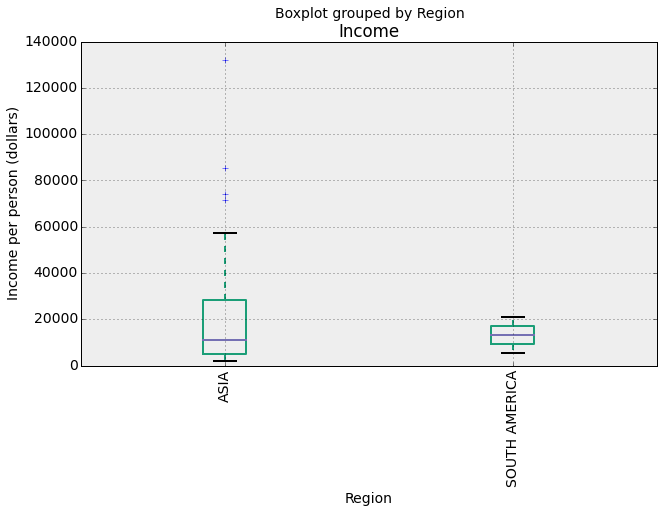

In [31]:
df = mergeByYear(2012)
df = df.loc[(df.Region == "ASIA") | (df.Region == "SOUTH AMERICA")]
df.boxplot('Income', by = 'Region', rot = 90)
plt.ylabel('Income per person (dollars)')

In [32]:
def ratioCountries(groupedData, a):
    prop = [len(group.Income[group.Income >= a]) / float(len(group.Income.dropna())) for key, group in groupedData]
    z = pd.DataFrame(groupedData.mean().index, columns = ['Region'])
    z['Mean'] = np.round(groupedData.mean().values,2)
    z['P(X > %g)' % a] = np.round(prop, 4)
    return z

df = mergeByYear(2012).groupby('Region')
df_ratio = ratioCountries(df, 1e4)
df_ratio = df_ratio[(df_ratio.Region == 'ASIA') | (df_ratio.Region == 'SOUTH AMERICA')]
df_ratio

,Region,Mean,P(X > 10000)
1,ASIA,22997.58,0.5526
5,SOUTH AMERICA,12956.60,0.7500


In [33]:
# First import the population data:
population_link = 'https://spreadsheets.google.com/pub?key=phAwcNAVuyj0XOoBL_n5tAQ&output=xls'
source = StringIO.StringIO(requests.get(population_link).content)
population = pd.read_excel(source, sheetname = "Data")

# Put years as index and countries as column names
population.columns = ['Country'] + map(int, list(population.columns)[1:])
population.head()

,Country,1700,1730,1750,1785,1786,1787,1788,1789,1790,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,Abkhazia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26693486,27614718,28420974,29145841,29839994,30577756,31411743,32358260,33397058,34499915
2,Akrotiri and Dhekelia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,15700,NaN,NaN,15700,NaN,NaN,NaN,NaN,NaN
3,Albania,300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3124861,3141800,3156607,3169665,3181397,3192723,3204284,3215988,3227373,3238316
4,Algeria,1750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32396048,32888449,33391954,33906605,34428028,34950168,35468208,35980193,36485828,36983924


In [34]:
def mergeByYearWithPop(year):

    # income DataFrame
    income_df = pd.DataFrame(income.ix[year].values, columns = ['Income'])
    income_df['Country'] = income.columns

    # merge income DataFrame and countries
    joined = pd.merge(income_df, countries, how="inner", on=['Country'])
    
    # population DataFrame
    population_df = population[['Country',year]]

    # merge population DataFrame and joined DataFrame 
    joined = pd.merge(joined, population_df, how="inner", on=['Country'])
    joined.columns = list(joined.columns[:-1])+['TotalPopulation']
    joined.Income = np.round(joined.Income, 2)
    
    def func(df):
        totPop = df.sum()['TotalPopulation']
        dfout = df
        dfout['AdjustedIncome'] = df.Income * df.TotalPopulation / float(totPop)
        dfout.AdjustedIncome = np.round(dfout.AdjustedIncome, 2)
        return dfout
        
    # Group by region
    returnDataFrame = joined.groupby('Region').apply(func)
        
    return returnDataFrame

mergeByYearWithPop(2012).head()

,Income,Country,Region,TotalPopulation,AdjustedIncome
0,1885.36,Afghanistan,ASIA,33397058,15.55
1,10122.61,Albania,EUROPE,3227373,54.72
2,12751.72,Algeria,AFRICA,36485828,488.72
3,41925.91,Andorra,EUROPE,87518,6.15
4,7244.83,Angola,AFRICA,20162517,153.44


In [35]:
df = mergeByYearWithPop(2012).groupby('Region').sum()
df.Income = mergeByYear(2012).groupby('Region').mean().Income
df.Income = np.round(df.Income, 2)
df = df.ix[['ASIA', 'SOUTH AMERICA']]
df

,Income,TotalPopulation,AdjustedIncome
Region,,,
ASIA,22997.58,4048448110,9581.04
SOUTH AMERICA,12956.60,400557572,14108.43


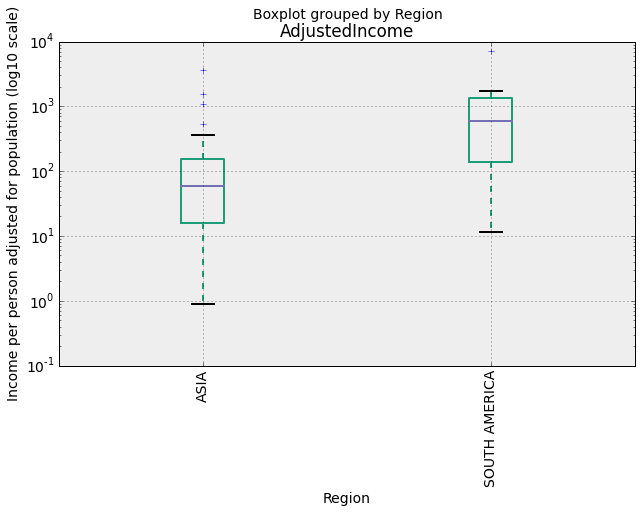

In [41]:
df = mergeByYearWithPop(2012)
df.AdjustedIncome = df['AdjustedIncome']
df = df[(df.Region == 'ASIA') | (df.Region == 'SOUTH AMERICA')]
df.boxplot('AdjustedIncome', by = 'Region', rot = 90)
plt.yscale('log')
plt.ylabel('Income per person adjusted for population (log10 scale)')

In [37]:
def ratioCountries(groupedData, a):
    prop = [len(group.AdjustedIncome[group.AdjustedIncome >= a]) / float(len(group.AdjustedIncome.dropna())) for key, group in groupedData]
    z = pd.DataFrame(groupedData.mean().index, columns = ['Region'])
    z['AdjustedIncome'] = np.round(groupedData.AdjustedIncome.sum().values,2)
    z['P(X > %g)' % a] = np.round(prop,4)
    return z

In [38]:
df = mergeByYearWithPop(2012).groupby('Region')
df_ratio = ratioCountries(df, 1e4)
df_ratio = df_ratio[(df_ratio.Region == 'ASIA') | (df_ratio.Region == 'SOUTH AMERICA')]
df_ratio

,Region,AdjustedIncome,P(X > 10000)
1,ASIA,9581.04,0
5,SOUTH AMERICA,14108.43,0


In [39]:
df = mergeByYearWithPop(2012).groupby('Region')
df_ratio = ratioCountries(df, 1e3)
df_ratio = df_ratio[(df_ratio.Region == 'ASIA') | (df_ratio.Region == 'SOUTH AMERICA')]
df_ratio

,Region,AdjustedIncome,P(X > 1000)
1,ASIA,9581.04,0.0789
5,SOUTH AMERICA,14108.43,0.3333
